In [1]:
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# calculate HR

In [2]:
def lgth_transform(ecg, ws):
    lgth=ecg.shape[0]
    sqr_diff=np.zeros(lgth)
    diff=np.zeros(lgth)
    ecg=np.pad(ecg, ws, 'edge')
    for i in range(lgth):
        temp=ecg[i:i+ws+ws+1]
        left=temp[ws]-temp[0]
        right=temp[ws]-temp[-1]
        diff[i]=min(left, right)
        diff[diff<0]=0

    return np.multiply(diff, diff)

def integrate(ecg, ws):
    lgth=ecg.shape[0]
    integrate_ecg=np.zeros(lgth)
    ecg=np.pad(ecg, math.ceil(ws/2), mode='symmetric')
    for i in range(lgth):
        integrate_ecg[i]=np.sum(ecg[i:i+ws])/ws
    return integrate_ecg

def find_peak(data, ws):
    lgth=data.shape[0]
    true_peaks=list()
    for i in range(lgth-ws+1):
        temp=data[i:i+ws]
        if np.var(temp)<5:
            continue
        index=int((ws-1)/2)
        peak=True
        for j in range(index):
            if temp[index-j]<=temp[index-j-1] or temp[index+j]<=temp[index+j+1]:
                peak=False
                break

        if peak is True:
            true_peaks.append(int(i+(ws-1)/2))
    return np.asarray(true_peaks)

def find_R_peaks(ecg, peaks, ws):
    num_peak=peaks.shape[0]
    R_peaks=list()
    for index in range(num_peak):
        i=peaks[index]
        if i-2*ws>0 and i<ecg.shape[0]:
            temp_ecg=ecg[i-2*ws:i]
            R_peaks.append(int(np.argmax(temp_ecg)+i-2*ws))
    return np.asarray(R_peaks)

def EKG_QRS_detect(ecg, fs):
    sig_lgth=ecg.shape[0]
    ecg=ecg-np.mean(ecg)
    ecg_lgth_transform=lgth_transform(ecg, int(fs/20))

    ws=int(fs/8)
    ecg_integrate=integrate(ecg_lgth_transform, ws)/ws
    ws=int(fs/6)
    ecg_integrate=integrate(ecg_integrate, ws)
    ws=int(fs/36)
    ecg_integrate=integrate(ecg_integrate, ws)
    ws=int(fs/72)
    ecg_integrate=integrate(ecg_integrate, ws)

    peaks=find_peak(ecg_integrate, int(fs/10))
    R_peaks=find_R_peaks(ecg, peaks, int(fs/40))
    
    return R_peaks

    
def get_HR(ecg, fs=256, sec=15):
    R_peaks = EKG_QRS_detect(ecg, fs)
    
    return len(R_peaks) * (60 / sec)

# load info

In [3]:
base = os.path.join(os.getcwd(), 'data')

video_info = pd.read_csv(os.path.join(base, 'video_info.csv'))
signal_info = pd.read_csv(os.path.join(base, 'signal_info.csv'))

# create DataSet

In [4]:
def get_data(index, sec=1):
    video_length = video_info.loc[index, 'length']
    video_fps = video_info.loc[index, 'fps']
    
    signal_length = signal_info.loc[index, 'length']
    signal_fps = signal_info.loc[index, 'sample_rate']
    data = np.load(signal_info.loc[index, 'signal_path'])
    
    length = int(min(video_length // video_fps, signal_length // signal_fps))
    
    sec_length = sec * signal_fps
    start_length = 59 * signal_fps
    iter_length = length - 59
    
    for i in range(iter_length):
        X = data[start_length + sec_length * i: start_length + sec_length * (i + 1)]
        Y = data[sec_length * i: start_length + sec_length * (i + 1)]
        hr = get_HR(Y, signal_fps, 60)
        
        yield (X, Y, hr)

In [5]:
dataset = pd.DataFrame(columns=['X', 'Y', 'HR'])
video_size = len(video_info.index)
index = 0

for i in tqdm(video_info.index):
    for data in get_data(i):
        dataset.loc[index] = data
        index += 1

 28%|████████████████████▊                                                     | 148/527 [8:16:08<21:10:30, 201.14s/it]


KeyboardInterrupt: 

In [ ]:
dataset.to_csv(os.path.join(base, 'signal_data.csv'))

In [ ]:
display(dataset.head(5))

In [ ]:
----

15360 [ 2399  3960  4546  6747  6942  7726  8330  8535  8738  9724 10113 11506
 11705 15292]


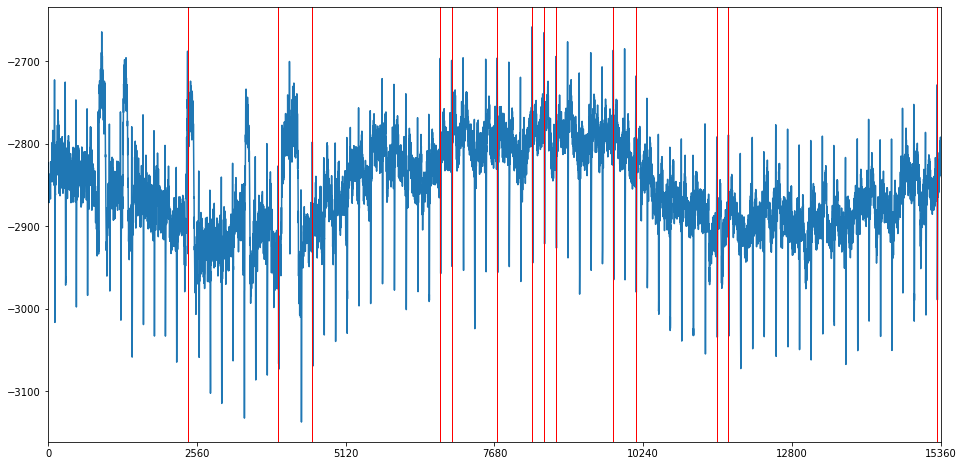

In [33]:
fs = 256
seg_unit = fs * 60
start = 0

for i in range(10):
    plt.figure(figsize=(16,8))
    x = list(range(seg_unit))
    y = data[start:start+seg_unit]
    
    R_peaks = EKG_QRS_detect(y, fs)
    
    print(len(x), R_peaks)
    
    plt.plot(x, y)
    for peak in R_peaks:
        plt.axvline(x=peak, color='r', linewidth=1)
    plt.xticks([i * fs * 10 for i in range(0, 7)])
    plt.xlim(0, seg_unit)
    plt.show()

    start += fs
    break

In [ ]:
import multiprocessing as mp

def load_dataset(dataset, name):
    base = os.path.join(os.getcwd(), 'data', name)
    dataset['X'] = list()
    dataset['Y'] = list()

    for folder in os.listdir(base):
        for file in os.listdir(os.path.join(base, folder)):
            if file.endswith('avi'):
                length = get_video_length(os.path.join(base, folder, file))
            elif file.endswith('npy'):
                data = np.load(os.path.join(base, folder, file))

        for x, y in iter_ecg(data, length):
            dataset['X'].append(x)
            dataset['Y'].append(y)

dataset = dict([(name, dict()) for name in names])
process = list()

for name in names:
    p = mp.Process(load_dataset, args=(dataset[name], name))
    p.start()
    
    process.append(p)